In [1]:

const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
using ParallelStencil
using ParallelStencil.FiniteDifferences3D
using ProgressMeter

using Plots, Printf, Statistics



@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
using GeoPhyInv


In [10]:


@parallel function compute_V!(Vx::Data.Array, Vy::Data.Array, Vz::Data.Array, tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array, tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array, dt::Data.Number, rho::Data.Number, dx::Data.Number, dy::Data.Number, dz::Data.Number)
    @inn(Vx) = @inn(Vx) - dt/rho*(@d_xi(tauxx)/dx+@d_ya(tauxy)/dy+@d_za(tauxz)/dz)
    @inn(Vy) = @inn(Vy) - dt/rho*(@d_xa(tauxy)/dx+@d_yi(tauyy)/dy+@d_za(tauyz)/dz)
    @inn(Vz) = @inn(Vz) - dt/rho*(@d_xa(tauxz)/dx+@d_ya(tauyz)/dy+@d_zi(tauzz)/dz)
    return
end

@parallel function compute_tauii!(tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array,Vx::Data.Array, Vy::Data.Array, Vz::Data.Array, dt::Data.Number, lambda2mu::Data.Array, lambda::Data.Array, dx::Data.Number, dy::Data.Number, dz::Data.Number)
    @all(tauxx) = @all(tauxx) - dt*(@all(lambda2mu)*@d_xa(Vx)/dx + @all(lambda)*(@d_ya(Vy)/dy + @d_za(Vz)/dz))
    @all(tauyy) = @all(tauyy) - dt*(@all(lambda2mu)*@d_ya(Vy)/dy + @all(lambda)*(@d_xa(Vx)/dx + @d_za(Vz)/dz))
    @all(tauzz) = @all(tauzz) - dt*(@all(lambda2mu)*@d_za(Vz)/dz + @all(lambda)*(@d_xa(Vx)/dx + @d_ya(Vy)/dy))
    return
end

@parallel function compute_tauij!(tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array,Vx::Data.Array, Vy::Data.Array, Vz::Data.Array, dt::Data.Number, mu::Data.Array, dx::Data.Number, dy::Data.Number, dz::Data.Number)
    @all(tauxz) = @all(tauxz) - dt*(@av_xzi(mu)*(@d_zi(Vx)/dz + @d_xi(Vz)/dx))
    @all(tauxy) = @all(tauxy) - dt*(@av_xyi(mu)*(@d_yi(Vx)/dy + @d_xi(Vy)/dx))
    @all(tauyz) = @all(tauyz) - dt*(@av_yzi(mu)*(@d_zi(Vy)/dz + @d_yi(Vz)/dy))
    return
end

compute_tauij! (generic function with 1 method)

In [22]:
##################################################
# @views function acoustic3D()
	nx, ny, nz = 255, 255, 255     # numerical grid resolution; should be a mulitple of 32-1 for optimal GPU perf
	# Physics
	lx, ly, lz = 1000., 1000.0, 1000.0  # domain extends
	vp0=3000
	vs0=2000
	rho          = 1.0               # density
	lambda     = @zeros(nx,ny,nz)               # lame parameter
	mu     = @zeros(nx,ny,nz)  
	mu .=  vs0*vs0*rho            # mu parameter
	lambda .= vp0*vp0*rho .- (2 .* mu)
	lambda2mu = lambda .+ (2 .* mu)
	tmax          = 1
	nt         = 1000              # number of timesteps
	tgrid=range(0,tmax,length=nt)              # physical time
	wav=GeoPhyInv.ricker(5.,tgrid)
	# Numerics
	nout       = 100                # plotting frequency
	# Derived numerics
	dx, dy, dz = lx/(nx-1), ly/(ny-1), lz/(nz-1) # cell sizes
	# Array allocations
	tauxx          = @zeros(nx,ny,nz)
	tauyy          = @zeros(nx,ny,nz)
	tauzz          = @zeros(nx,ny,nz)

	tauxy          = @zeros(nx-1,ny-1,nz-2)

	tauxz          = @zeros(nx-1,ny-2,nz-1)

	tauyz          = @zeros(nx-2,ny-1,nz-1)
    
	Vx         = @zeros(nx+1,ny,nz)
	Vy         = @zeros(nx,ny+1,nz)
	Vz         = @zeros(nx,ny,nz+1)
	# Initial conditions
	# tauxx         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
	# tauyy         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
	# tauzz         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
	dt         = min(dx,dy,dz)/sqrt(vp0*vp0+vs0*vs0)/6
	println([dt, dx,dz,dy])
	# dt=1e-5
	# wefwrg
	# Preparation of visualisation
	y_sl       = Int(ceil(ny/2))
	X, Y, Z    = -lx/2:dx:lx/2, -ly/2:dy:ly/2, -lz/2:dz:lz/2


[0.00018198825335473398, 3.937007874015748, 3.937007874015748, 3.937007874015748]


(-500.0:3.937007874015748:500.0, -500.0:3.937007874015748:500.0, -500.0:3.937007874015748:500.0)

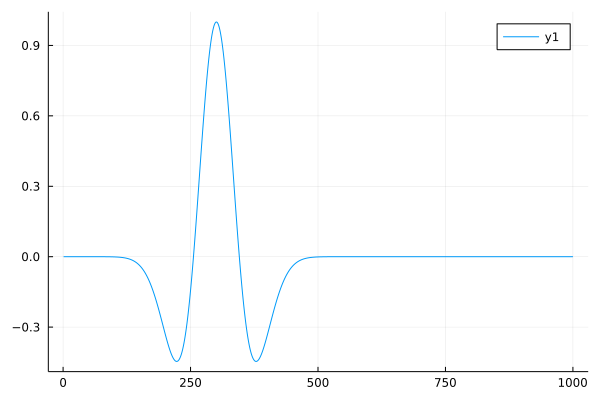

In [23]:
plot(wav)

Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


Total steps=1000, time=2.038e+01 sec (@ T_eff = 52.00 GB/s) 


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
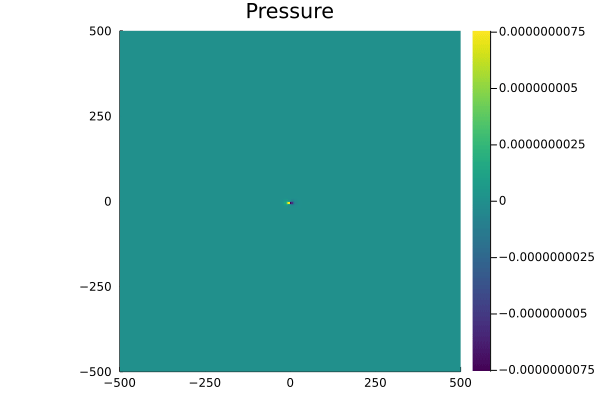

In [24]:
	

	ENV["GKSwstype"]="nul"; if isdir("viz3D_out")==false mkdir("viz3D_out") end; loadpath = "./viz3D_out/"; anim = Animation(loadpath,String[])
	println("Animation directory: $(anim.dir)")
	# Time loop
	@showprogress for it = 1:nt
	    if (it==11)  global wtime0 = Base.time()  end
	   
	    @parallel compute_tauii!(tauxx,tauyy,tauzz, Vx, Vy, Vz, dt, lambda2mu, lambda, dx, dy, dz)
	    @parallel compute_tauij!(tauxy,tauxz,tauyz, Vx, Vy, Vz, dt, mu, dx, dy, dz)
	    @parallel compute_V!(Vx, Vy, Vz, tauxx,tauyy,tauzz,tauxy,tauxz,tauyz, dt, rho, dx, dy, dz)
	    tauxx[div(nx,2),div(ny,2),div(nz,2)]=wav[it]
	    # t = t + dt
	    # Visualisation
	    if mod(it,nout)==0
		heatmap(X,Z,Array(Vx)[1:end-1,y_sl,:]', aspect_ratio=1, xlims=(X[1],X[end]), ylims=(Z[1],Z[end]), c=:viridis, title="Pressure"); frame(anim)
	    end
	end
	# Performance
	wtime    = Base.time() - wtime0
	A_eff    = (4*2)/1e9*nx*ny*nz*sizeof(Data.Number)  # Effective main memory access per iteration [GB] (Lower bound of required memory access: H and dHdτ have to be read and written (dHdτ for damping): 4 whole-array memaccess; B has to be read: 1 whole-array memaccess)
	wtime_it = wtime/(nt-10)                           # Execution time per iteration [s]
	T_eff    = A_eff/wtime_it                          # Effective memory throughput [GB/s]
	@printf("Total steps=%d, time=%1.3e sec (@ T_eff = %1.2f GB/s) \n", nt, wtime, round(T_eff, sigdigits=2))
	gif(anim, "acoustic3D.gif", fps = 15)
	# return
    # end
    
    
    # acoustic3D()
    

